In [2]:
import numpy as np
import numpy.linalg as LA
import torch
from torchvision import datasets,transforms
import time
import matplotlib.pyplot as plt

### Construct mnist_568

In [3]:
train_dt = datasets.MNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)
test_dt = datasets.MNIST(root='./data',train=False,transform=transforms.ToTensor(),download=True)
train_data,train_label = train_dt._load_data()
test_data,test_label = test_dt._load_data()

train_indice_568 = torch.logical_or(train_label==5,torch.logical_or(train_label==6,train_label==8))
test_indice_568 = torch.logical_or(test_label==5,torch.logical_or(test_label==6,test_label==8))
train_data = train_data[train_indice_568].reshape(-1,28*28).numpy()
train_label = train_label[train_indice_568].numpy()
test_data = test_data[test_indice_568].reshape(-1,28*28).numpy()
test_label = test_label[test_indice_568].numpy()

In [4]:
len(train_label),len(test_label)

(17190, 2824)

In [5]:
np.random.seed(2022)
train_indice = np.random.permutation(len(train_data))
test_indice = np.random.permutation(len(test_data))
x_train = train_data[train_indice[:15000]]
y_train = train_label[train_indice[:15000]]
x_test = test_data[test_indice[:2500]]
y_test = test_label[test_indice[:2500]]

### Data preparation

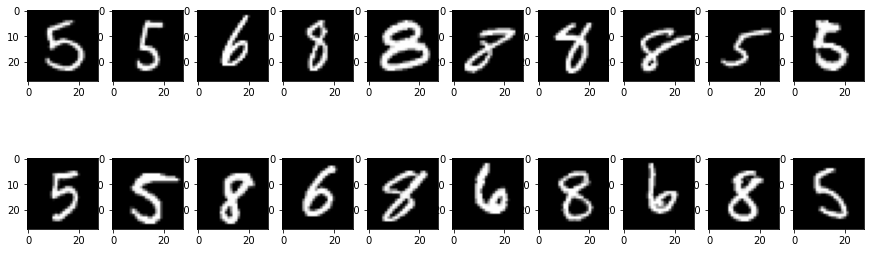

In [6]:
np.random.seed(2022)
pick_indice_1 = np.random.permutation(len(x_train))[:10]
pick_indice_2 = np.random.permutation(len(x_test))[:10]

## visualize training set and testing set
fig,ax = plt.subplots(2,10,figsize=(15,5))

for i in range(10):
    ax[0,i].imshow(x_train[pick_indice_1[i]].reshape(28,28),cmap='gray')
for j in range(10):
    ax[1,j].imshow(x_test[pick_indice_2[j]].reshape(28,28),cmap='gray')

plt.show()

In [7]:
print(f'For the training dataset,the corresponding label are {y_train[pick_indice_1]}')
print(f'For the testing dataset,the corresponding label are {y_test[pick_indice_2]}')

For the training dataset,the corresponding label are [5 5 6 8 8 8 8 8 5 5]
For the testing dataset,the corresponding label are [5 5 8 6 8 6 8 6 8 5]


In [8]:
## normalize training and testing dataset 
norm_1 = LA.norm(x_train,ord=2,axis=1).reshape(-1,1)
x_train = x_train/norm_1

norm_2 = LA.norm(x_test,ord=2,axis=1).reshape(-1,1)
x_test = x_test/norm_2

### Evaluation function

In [9]:
d = 28*28
eps = 0.32
d_p = int(4*np.log(len(x_train)+len(x_test))/(eps**2-eps**3))
R = np.random.randn(d,d_p)

In [12]:
d_p

561

In [10]:
from scipy.spatial.distance import cdist

def dist(Xtrain,Xtest):
    Xtrain_p = 1./np.sqrt(d_p)*Xtrain@R
    Xtest_p = 1./np.sqrt(d_p)*Xtest@R
    M = cdist(Xtrain_p,Xtest_p)
    return M

def retrieve_k(i,M,k):
    dist = M[:,i]
    sorted_indice = np.argsort(dist)
    k_indice = sorted_indice[:k]
    return k_indice

def precision_k(y,ytrain,I):
    return (y==ytrain[I]).mean()

def avg_precision_k(Xtrain,ytrain,Xtest,ytest,k):
    result = 0
    M = dist(Xtrain,Xtest)
    for i in range(len(Xtest)):
        k_indice = retrieve_k(i,M,k)
        result += precision_k(ytest[i],ytrain,k_indice)
    result /= len(Xtest)
    return result
    

### Retrieval performance

In [11]:
avg_pre_list = []
runing_time_list = []
k_list = [1,2,5,10,20,50,100,200,500,1000]
for k in k_list:
    start = time.time()
    result = avg_precision_k(x_train,y_train,x_test,y_test,k)
    avg_pre_list.append(result)
    end = time.time()
    runing_time_list.append(end-start)

In [19]:
avg_pre_list

[0.9836,
 0.9832,
 0.9788799999999994,
 0.9742000000000022,
 0.9680200000000001,
 0.9538720000000067,
 0.938852,
 0.9171859999999921,
 0.8727976000000035,
 0.8174904000000026]

In [20]:
runing_time_list

[18.635037183761597,
 15.524598598480225,
 15.64721965789795,
 15.976155042648315,
 16.091359853744507,
 15.485934495925903,
 15.718036413192749,
 16.05874276161194,
 15.665780544281006,
 15.49856686592102]

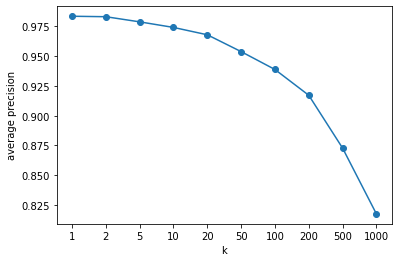

In [21]:
plt.plot(avg_pre_list,'o-')
plt.xticks(range(len(k_list)),k_list)
plt.xlabel('k')
plt.ylabel('average precision')
plt.show()